In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL.Image
import saliency.core as saliency

from tensorflow import convert_to_tensor, GradientTape
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

#from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, Huber

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#PATH_TO_DATA = 'drive/MyDrive/Projet DataScientest/annotated_regions/'
PATH_TO_DATA = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/annotated_regions/'

In [4]:
df = pd.read_csv('C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/label_df.csv')
df.head()

,filename,binary_class,annotation_class
0,C01_B003_S01_0.jpeg,1,1
1,C01_B003_S01_1.jpeg,1,1
2,C01_B003_S01_2.jpeg,1,1
3,C01_B003_S01_3.jpeg,1,1
4,C01_B008_S01_0.jpeg,0,0


In [5]:
df['filename'] = PATH_TO_DATA + df['filename']
df['class'] = df['annotation_class'].astype('string')
df = df[['filename', 'class']]

In [6]:
df_train=df.sample(frac=0.80, random_state=21).copy()
df_test=df.drop(df_train.index).copy()

In [7]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          #rescale=1 / 255.0,
                                          rotation_range=90,
                                          width_shift_range=0.1, 
                                          height_shift_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2,
                                          fill_mode = "constant",
                                          cval=255)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(df_train, 
                                                           class_mode="sparse",
                                                           subset="training"                                                         
                                                          )

validation_generator = train_data_generator.flow_from_dataframe(df_train, 
                                                           class_mode="sparse",
                                                           subset="validation"                                                            
                                                          )

test_generator = test_data_generator.flow_from_dataframe(df_test,
                                                         batch_size=1,
                                                         class_mode="sparse",
                                                         shuffle=False,
                                                    )

Found 3793 validated image filenames belonging to 4 classes.
Found 948 validated image filenames belonging to 4 classes.
Found 1185 validated image filenames belonging to 4 classes.


In [8]:
model_effnet = EfficientNetB7(include_top=False, 
                              input_shape=(256,256,3)
                             )

model_effnet.trainable = False  

model = Sequential()
model.add(model_effnet) 
model.add(GlobalAveragePooling2D())
#model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,931
Trainable params: 10,244
Non-trainable params: 64,097,687
_________________________________________________________________


In [10]:
model.compile(optimizer=Adam(learning_rate=5e-3), 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3,
                              patience=3)

history = model.fit(train_generator,
                    epochs=25, 
                    #workers=-1, 
                    #use_multiprocessing=True,
                    validation_data=validation_generator, 
                    callbacks=[reduce_lr]
                    )

Epoch 1/25
119/119 [==============================] - 135s 995ms/step - loss: 1.0287 - accuracy: 0.5600 - val_loss: 0.8867 - val_accuracy: 0.6245
Epoch 2/25
119/119 [==============================] - 107s 895ms/step - loss: 0.9145 - accuracy: 0.6188 - val_loss: 0.9104 - val_accuracy: 0.6403
Epoch 3/25
119/119 [==============================] - 109s 909ms/step - loss: 0.8768 - accuracy: 0.6335 - val_loss: 0.8477 - val_accuracy: 0.6487
Epoch 4/25
119/119 [==============================] - 108s 902ms/step - loss: 0.8467 - accuracy: 0.6557 - val_loss: 0.8722 - val_accuracy: 0.6276
Epoch 5/25
119/119 [==============================] - 110s 920ms/step - loss: 0.8599 - accuracy: 0.6525 - val_loss: 0.9696 - val_accuracy: 0.5949
Epoch 6/25
119/119 [==============================] - 110s 918ms/step - loss: 0.8213 - accuracy: 0.6662 - val_loss: 0.9035 - val_accuracy: 0.6498
Epoch 7/25
119/119 [==============================] - 111s 929ms/step - loss: 0.7565 - accuracy: 0.6968 - val_loss: 0.7982 -

In [12]:
model.save("C:/Users/gaelp/Documents/Projet_DataScientest/EfficientNetB7.h5")

In [14]:
# Evaluate the model
loss, acc = model.evaluate(test_generator, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

1185/1185 - 42s - loss: 0.8402 - accuracy: 0.6565
Untrained model, accuracy: 65.65%


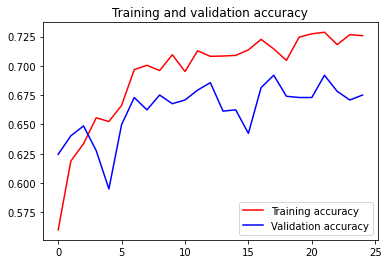

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [16]:
model = load_model('C:/Users/gaelp/Documents/Projet_DataScientest/EfficientNetB7.h5')

In [28]:
y_true = test_generator.classes
predict = model.predict_generator(test_generator) # remove steps if calculate to whole dataset
y_pred = np.argmax(predict, axis = 1)

In [29]:
# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

k = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print("Quadratic weighted Cohen's kappa = {:.4f}".format(k))
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[285  49  29  33]
 [ 94 127  56  29]
 [ 37  32 134  35]
 [  4   7   8 226]]

Quadratic weighted Cohen's kappa = 0.6923

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       396
           1       0.59      0.42      0.49       306
           2       0.59      0.56      0.58       238
           3       0.70      0.92      0.80       245

    accuracy                           0.65      1185
   macro avg       0.64      0.66      0.64      1185
weighted avg       0.64      0.65      0.64      1185




# 2. Learning rate tuning

In [8]:
def create_uncompiled_model():
    
    model_effnet = EfficientNetB7(include_top=False, 
                              input_shape=(256,256,3)
                              )

    model_effnet.trainable = False  

    model = Sequential()
    model.add(model_effnet) 
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    return model

In [19]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    early_stop = EarlyStopping(monitor='loss', patience=5)
    lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))
    
    # Select your optimizer
    optimizer = Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss='sparse_categorical_crossentropy', #tensorflow.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule, early_stop])
    
    return history

In [11]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
149/149 [==============================] - 128s 721ms/step - loss: 0.9928 - accuracy: 0.5765
Epoch 2/100
149/149 [==============================] - 108s 722ms/step - loss: 0.8879 - accuracy: 0.6222
Epoch 3/100
149/149 [==============================] - 111s 740ms/step - loss: 0.8329 - accuracy: 0.6482
Epoch 4/100
149/149 [==============================] - 111s 744ms/step - loss: 0.8502 - accuracy: 0.6454
Epoch 5/100
149/149 [==============================] - 111s 744ms/step - loss: 0.8282 - accuracy: 0.6499
Epoch 6/100
149/149 [==============================] - 113s 757ms/step - loss: 0.7937 - accuracy: 0.6661
Epoch 7/100
149/149 [==============================] - 113s 756ms/step - loss: 0.7787 - accuracy: 0.6750
Epoch 8/100
149/149 [==============================] - 113s 757ms/step - loss: 0.7923 - accuracy: 0.6640
Epoch 9/100
149/149 [==============================] - 112s 750ms/step - loss: 0.7666 - accuracy: 0.6741
Epoch 10/100
149/149 [==============================] -

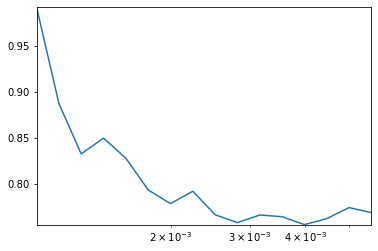

In [20]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], 
             lr_history.history["loss"])
plt.axis([np.min(lr_history.history["lr"]), 
          np.max(lr_history.history["lr"]), 
          np.min(lr_history.history["loss"]), 
          np.max(lr_history.history["loss"])]);